In [3]:
%load_ext tensorboard

In [1]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import TensorBoard

from keras.layers import Conv2D, MaxPool2D, Concatenate, AveragePooling2D, Dropout, Dense, GlobalAveragePooling2D, Flatten

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Dataset Exploration

In [7]:
train_ds, test_ds = tfds.load("cifar10", split = ['train','test'], as_supervised= True)
assert isinstance(train_ds, tf.data.Dataset)
print(train_ds)

<PrefetchDataset shapes: ((32, 32, 3), ()), types: (tf.uint8, tf.int64)>


(1024, 1024, 3)
7
(1024, 1024, 3)
8
(1024, 1024, 3)
4
(1024, 1024, 3)
4


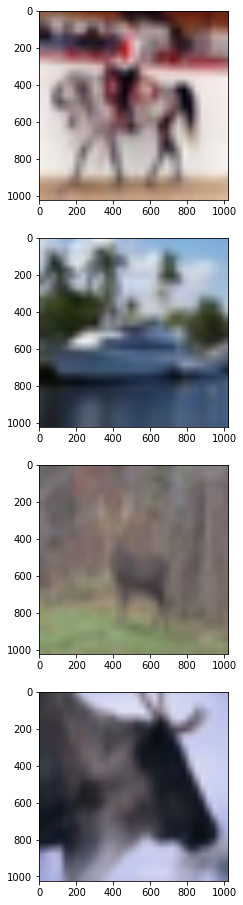

In [21]:
n = 4
fig, axs = plt.subplots(n, 1, figsize = (4, 4*n))
ds = train_ds.take(n)
i=0
for image, label in ds:
  image = tf.image.resize(image, [224,224])
  image = image/255.0
  print(image.shape)
  axs[i].imshow(image)
  print(label.numpy())
  i = i+1

TypeError: ignored

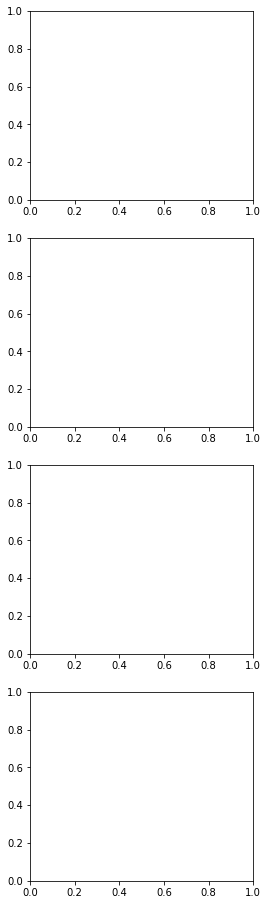

In [8]:
n = 4
fig, axs = plt.subplots(n, 1, figsize = (4, 4*n))
ds = train_ds.take(n)
i = 0
for example in ds:  
  image = example["image"]
  image = tf.image.resize(image, [224,224])
  image = image/255.0
  axs[i].imshow(image)
  axs[i].set_title("Image")
  label = example["label"]
  label = label.numpy()
  axs[i].text(1.5, 0.5, label,
              horizontalalignment='center',
     verticalalignment='center',
     transform = axs[i].transAxes)
  i=i+1


# Inception Net

In [ ]:
kernel_init = keras.initializers.glorot_uniform()
bias_init = keras.initializers.constant(value = 0.2)

In [ ]:
def conv_block(inputs, n_filters, name=None, filter_size = (1,1), stride_step = (1,1), padding_type='same'):
    x = Conv2D(n_filters, filter_size, padding=padding_type, strides = stride_step, activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init, name=name)(inputs)
    return x

In [ ]:
def auxiliary_block(inputs, n_classes, name):
    pool = AveragePooling2D(pool_size=(5,5), strides=(3,3))(inputs)
    conv = conv_block(pool, 128)
    flat = Flatten()(conv)
    fc_1 = Dense(1024, activation='relu')(flat)
    dropout = Dropout(0.7)(fc_1)
    fc_2 = Dense(n_classes, activation = 'softmax', name=name)(dropout)
    
    return fc_2

In [ ]:
def inception_module(x,
                     n_filters_1x1,
                     n_filters_3x3_reduce,
                     n_filters_3x3,
                     n_filters_5x5_reduce,
                     n_filters_5x5,
                     n_filters_pool_1x1, name):
    

  conv_1x1 = conv_block(x, n_filters_1x1)

  conv_3R = conv_block(x, n_filters_3x3_reduce)
  conv_3x3 = conv_block(conv_3R, n_filters_3x3, filter_size=(3,3))

  conv_5R = conv_block(x, n_filters_5x5_reduce)
  conv_5x5 = conv_block(conv_5R, n_filters_5x5,  filter_size=(5,5))

  max_pool = MaxPool2D(pool_size=(3, 3), strides=(1,1), padding='same')(x)
  pool_conv_1x1 = conv_block(max_pool, n_filters_pool_1x1)

  output = Concatenate(axis = 3, name=name)([conv_1x1, conv_3x3, conv_5x5, pool_conv_1x1])

  return output

In [ ]:
def inception_net(input_size=(224,224,3), n_classes=1000):
    
    inputs = keras.layers.Input(input_size)
    conv_1 = conv_block(inputs, 64,"Conv_1", (7,7), (2,2))
#     print("Conv_1 Output shape is ",conv_1.shape)

#     Add Local Resp Norm!
    pool_1 = MaxPool2D(pool_size=(3, 3), strides=(2,2), padding='same', name="Pool_1")(conv_1)
    pool_1 = tf.nn.local_response_normalization(pool_1, name="Local Resp Norm_1")
    conv_2a = conv_block(pool_1, 64, "Conv_2a", padding_type= 'valid')
    conv_2b = conv_block(conv_2a, 192,"Conv_2b", (3,3))    
    conv_2b = tf.nn.local_response_normalization(conv_2b, name="Local Resp Norm_2")
    
    pool_2 = MaxPool2D(pool_size=(3, 3), strides=(2,2), padding='same', name= "Pool_2")(conv_2b)
    inception_3a = inception_module(pool_2, 64, 96, 128, 16, 32, 32, name= "Inception_3a")
    inception_3b = inception_module(inception_3a, 128, 128, 192, 32, 96, 64, name= "Inception_3b")
    
    pool_3 = MaxPool2D(pool_size=(3,3), strides= (2,2), padding='same', name="Pool_3")(inception_3b)
    inception_4a = inception_module(pool_3, 192, 96, 208, 16, 48, 64, name= "Inception_4a")
    inception_4b = inception_module(inception_4a, 160, 112, 224, 24, 64, 64, name= "Inception_4b")
    inception_4c = inception_module(inception_4b, 128, 128, 256, 24, 64, 64, name= "Inception_4c")
    inception_4d = inception_module(inception_4c, 112, 144, 288, 32, 64, 64, name= "Inception_4d")
#     Auxiliary Classifier
    soft_0 = auxiliary_block(inception_4d, n_classes, "Soft_0");
    inception_4e = inception_module(inception_4d, 256, 160, 320, 32, 128, 128, name= "Inception_4e")
#     Auxiliary Classifier
    soft_1 = auxiliary_block(inception_4e, n_classes, "Soft_1");
    
    pool_4 = MaxPool2D(pool_size= (3,3), strides= (2,2), padding='same', name="Pool_4")(inception_4e)
    inception_5a = inception_module(pool_4, 256, 160, 320, 32, 128, 128, name= "Inception_5a")
    inception_5b = inception_module(inception_5a, 384, 192, 384, 48, 128, 128, name= "Inception_5b")
    
    pool_5 = AveragePooling2D(pool_size=(7,7), strides=(1,1), padding='valid', name="Pool_5")(inception_5b)
    drop_out = Dropout(0.4, name="Dropout")(pool_5)
    soft_2 = Dense(n_classes, activation='softmax', name="Soft_2")(drop_out)
      
#     With Aux Classifiers
    model = keras.Model(inputs = inputs, outputs = [soft_2, soft_1, soft_0])

#     model = keras.Model(inputs = inputs, outputs = soft_2)

    return model

inception_net()

In [ ]:
inception_net_model = inception_net(n_classes=1000)


In [ ]:
inception_net_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv_1 (Conv2D)                 (None, 112, 112, 64) 9472        input_10[0][0]                   
__________________________________________________________________________________________________
Pool_1 (MaxPooling2D)           (None, 56, 56, 64)   0           Conv_1[0][0]                     
__________________________________________________________________________________________________
tf.nn.local_response_normalizat (None, 56, 56, 64)   0           Pool_1[0][0]                     
____________________________________________________________________________________________